*Be sure to Pip install any necessary packages before running the first cell*

In [1]:
import pandas as pd
import os
import numpy as np
import re
import networkx as nx
import matplotlib 
from matplotlib import pyplot as plt
import linkcom

In [5]:
## pip install networkx

     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     -- ------------------------------------- 0.1/2.1 MB 3.6 MB/s eta 0:00:01
     ------- -------------------------------- 0.4/2.1 MB 4.6 MB/s eta 0:00:01
     ------------ --------------------------- 0.6/2.1 MB 4.9 MB/s eta 0:00:01
     -------------- ------------------------- 0.7/2.1 MB 4.2 MB/s eta 0:00:01
     ----------------------------- ---------- 1.5/2.1 MB 6.4 MB/s eta 0:00:01
     ---------------------------------------- 2.1/2.1 MB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
# note this package is needed to load the xlsx file
pip install openpyxl

     ---------------------------------------- 0.0/250.0 kB ? eta -:--:--
     ----------------- -------------------- 112.6/250.0 kB 3.3 MB/s eta 0:00:01
     -------------------------------------  245.8/250.0 kB 3.0 MB/s eta 0:00:01
     -------------------------------------- 250.0/250.0 kB 3.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [71]:
## pip install git+https://github.com/Nathaniel-Rodriguez/linkcom.git

  Cloning https://github.com/Nathaniel-Rodriguez/linkcom.git to c:\users\anne wesley\appdata\local\temp\pip-req-build-3_n79bh0
  Resolved https://github.com/Nathaniel-Rodriguez/linkcom.git to commit 741f0ab54cc28704031613fba979b8cd15039ef5
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for linkcom: filename=linkcom-0.1-py3-none-any.whl size=20826 sha256=65c09f6f819f627afbead3d42c60cd1239fa75b69e4bdc32ca7d85f389ad3dd8
  Stored in directory: C:\Users\Anne Wesley\AppData\Local\Temp\pip-ephem-wheel-cache-sh78wtw3\wheels\48\38\cc\cab810b7f79688148b2e0a416f74bc7856eb460c5ed4406557
Successfully built linkcom
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/Nathaniel-Rodriguez/linkcom.git 'C:\Users\Anne Wesley\AppData\Local\Temp\pip-req-build-3_n79bh0'


# Functions

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('mode.chained_assignment', None)

In [3]:
def is_float(x):
    try:
        float(x)
        return True
    except:
        return False

In [4]:
def reverse_questions(d, r_list):
    '''
    d = dataframe object
    r_list = list of lists containing questions that need to be reverse scored
    reverse scoring indicates subtracting the total range of possible answers from the answer 
    and taking the absolute value. For example, if a question was answered as a 2 on a 1 to 5
    scale in a reverse scaled question, that answer would correspond to:
        abs(2-6) = 4 on a normal scale.
    '''
    for i in range(len(r_list)):
        for x in rev_list[i]:
            num = max(d[x]) + min(d[x])
            d[x] = abs(d[x] - num)

In [5]:
def test_corr(x, d, thresh, cutoff, corr_type):
    '''
        function for generating the correlation to overall score for each individual test. 
        Takes 2 inputs:
            x = regex string to identify the test
            d = overall dataframe containing the test
            thresh = a number between 0 and 1, any correlation under this value will be dropped to 0
            cutoff = greater than or equal to cutoff point for which a score is attributed to well being, 
            for example, scores equal to or greater than 4.0 are considered positive.
            corr_type = pearson, spearman or kendall
        function returns a dict of correlations to overall score after filtering out any score 
        below the threshold.
    '''
    # filter dataframe to regex string x
    df1 = d.filter(regex = x) #to handle any NA values
    
    ## code in specific test scoring
    ## for whoqol - mean score across all questions
    ## for who5, pgwbi sum across all questions
    ## for sf36 mean score across all questions
    
    if x == '^who5' or x == '^pgwbi':
        df1['overall_score'] = df1.sum(axis = 1)
        
    else:
        df1['overall_score'] = df1.mean(axis = 1)

    
    # filter dataframe to above wellbeing cutoff
    df1_filtered = df1[df1['overall_score'] >= cutoff]
    
    #drop overall score
    df1_filtered.drop('overall_score', axis=1, inplace = True)    
    
    # run correlation 
    corr_df = df1_filtered.corr(method = corr_type)
    
    # update correlation values of 1 and negative to reflect 0s
    corr_df = corr_df.mask(corr_df == 1, 0)
    corr_df = corr_df.mask(corr_df < thresh, 0)
    
    # return dict
    return corr_df

In [6]:
def visualize_graph(df):

    n = nx.from_pandas_adjacency(df)

    # print graph with edge labels
    widths = nx.get_edge_attributes(n, 'weight')
    nodelist = n.nodes()
    labels = nx.get_edge_attributes(n,'weight')
    labels = {key: round(value, 2) for key, value in labels.items()}

    plt.figure(figsize=(10,8))

    pos = nx.random_layout(n)
    nx.draw_networkx_nodes(n, pos,
                           nodelist = nodelist,
                           node_size = 1000,
                           node_shape = 'o',
                           node_color = 'gray',
                           alpha = 0.8)
    nx.draw_networkx_edges(n, pos,
                           edgelist = widths.keys(),
                           width = list(widths.values()),
                           edge_color = 'blue',
                           alpha = 0.7,
                           node_size = 1000)
    nx.draw_networkx_labels(n, pos = pos,
                            labels = dict(zip(nodelist,nodelist)),
                            font_color = 'black',
                            font_size = 6)
    nx.draw_networkx_edge_labels(n, pos = pos, 
                                 edge_labels = labels,
                                font_size = 8,
                                font_color = 'black')
    plt.show()

In [7]:
def form_link_comm(d):
    '''
    d = pandas dataframe that will be translated into a graph
    '''
    # form weighted graph
    g = nx.from_pandas_adjacency(d)

    # run linkcom.cluster
    e2c, S, D, Dlist = linkcom.cluster(g, is_weighted = True)
    
    #set edge attributes of graph
    nx.set_edge_attributes(g, e2c, 'linkcomm')

    return g

# Set Working Directory & Import Dataset

In [10]:
# set working directory

#os.chdir('C:\\Users\\Anne Wesley\\Documents\\IU\\network_science\\group_project')

os.getcwd()

'C:\\Users\\Anne Wesley\\Documents\\IU\\network_science\\group_project'

In [8]:
# Import Dataset

#data = pd.read_excel('qol_data.xlsx')

data = pd.read_excel('Quality of Life Dataset.xlsx')

In [9]:
# Copy to preserve data

df = data.copy(deep = True)

# Data Cleaning

In [10]:
# Clean up Dataset

# first three columns are empty - drop
df.drop(df.columns[[0,1,2]], axis = 1, inplace = True) 

# lower column names
df.columns = [x.lower() for x in df.columns] 

In [11]:
df.head()

,age,bio_sex,gender,race_1,race_2,race_3,race_4,race_5,race_6,race_7,hispanic,orientation,marital_status,rel_services,education,income,employment,medication,psych_medication,psych_medication_3_text,support,phys_health,audit_1,tipi_1,tipi_2,tipi_3,tipi_4,tipi_5,tipi_6,tipi_7,tipi_8,tipi_9,tipi_10,erq_1,erq_2,erq_3,erq_4,erq_5,erq_6,erq_7,erq_8,erq_9,erq_10,mansa_1,mansa_2,mansa_3,mansa_4,mansa_5,mansa_6,mansa_7,mansa_8,mansa_9,mansa_10,mansa_11,mansa_12,eq5d_1,eq5d_2,eq5d_3,eq5d_4,eq5d_5,qlesq_med_1,qlesq_med_2,qlesq_med_3,qlesq_med_4,qlesq_med_5,qlesq_med_6,qlesq_med_7,qlesq_med_8,qlesq_med_9,qlesq_med_10,qlesq_med_11,qlesq_med_12,qlesq_med_13,qlesq_med_14,qlesq_med_15,qlesq_med_16,qlesq_nomed_1,qlesq_nomed_2,qlesq_nomed_3,qlesq_nomed_4,qlesq_nomed_5,qlesq_nomed_6,qlesq_nomed_7,qlesq_nomed_8,qlesq_nomed_9,qlesq_nomed_10,qlesq_nomed_11,qlesq_nomed_12,qlesq_nomed_13,qlesq_nomed_14,qlesq_nomed_15,whoqol_1_1,whoqol_2_1,whoqol_3,whoqol_4,whoqol_5,whoqol_6,whoqol_7,whoqol_8,whoqol_9,whoqol_10,whoqol_11,whoqol_12,whoqol_13,whoqol_14,whoqol_15,whoqol_16,whoqol_17,whoqol_18,whoqol_19,whoqol_20,whoqol_21,whoqol_22,whoqol_23,whoqol_24,whoqol_25,whoqol_26,who5_1,who5_2,who5_3,who5_4,who5_5,k6_2,k6_3,k6_4,k6_5,k6_6,k6_7,pgwbi_1,pgwbi_2,pgwbi_3,pgwbi_4,pgwbi_5,pgwbi_6,pgwbi_7,pgwbi_8,pgwbi_9,pgwbi_10,pgwbi_11,pgwbi_12,pgwbi_13,pgwbi_14,pgwbi_15,pgwbi_16,pgwbi_17,pgwbi_18,pgwbi_19,pgwbi_20,pgwbi_21,pgwbi_22,sf36_13,sf36_14,sf36_15,sf36_16,sf36_17,sf36_18,sf36_19,sf36_20,sf36_21,sf36_22,sf36_23,sf36_24,sf36_25,sf36_26,sf36_27,sf36_28,sf36_29,sf36_30,sf36_31,sf36_32,mansa_yn_1,mansa_yn_2,mansa_yn_3,mansa_yn_4,sf36_1,sf36_2,sf36_3_,sf36_4,sf36_5,sf36_6,sf36_7,sf36_8,sf36_9,sf36_10,sf36_11,sf36_12,sf36_33,sf36_34,sf36_35,sf36_36
0,41,1,1,1,0,0,0,0,0,0,2,1,3,4,2,4,1,2,NaN,NaN,3,3,1,3,1,5,2,5,6,6,1,6,6,5,3,4,2,2,1,2,3,2,2,4,4,2,6,3,4,5,6,1,6,2,2,1,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.0,2.0,3.0,4.0,2.0,3.0,1.0,2.0,3.0,4.0,4.0,4.0,4.0,4,2,2,1,2,2,2,4,2,1,1,2,4,2,5,1,4,4,4,4,1,2,2,2,2,5,1,2,2,0,0,1,2,2,2,3,2,4,2,2,0,5,5,4,3,4,1,1,0.0,3.0,0.0,0.0,5.0,3.0,4.0,2.0,1.0,5.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,4.0,4.0,2.0,6.0,6.0,2.0,5.0,6.0,2.0,2.0,5.0,1.0,2.0,1.0,1.0,0.0,0.0,4.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,5.0,2.0,2.0,4.0
1,32,1,1,0,0,0,0,0,1,0,2,1,3,4,5,9,1,2,NaN,NaN,3,2,4,2,4,5,4,7,6,6,4,5,4,5,6,6,4,4,4,5,5,4,4,6,5,6,4,5,6,7,7,6,4,5,7,1,1,1,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,4.0,4.0,4.0,2.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0,5.0,3.0,5,4,3,1,4,4,5,5,5,5,5,5,5,4,4,4,4,5,4,3,5,3,4,4,5,2,4,4,4,1,4,1,1,0,0,1,0,1,3,4,0,5,1,1,3,1,1,5,2.0,3.0,0.0,3.0,2.0,4.0,5.0,1.0,4.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,3.0,5.0,6.0,2.0,3.0,5.0,5.0,2.0,4.0,5.0,1.0,0.0,0.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,2.0
2,58,1,1,1,0,0,0,0,0,0,2,3,1,1,5,4,1,2,NaN,NaN,2,4,5,6,6,5,3,6,2,6,5,5,5,6,4,6,2,6,2,6,6,2,6,2,2,1,2,2,1,7,6,1,5,1,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,3.0,2.0,2.0,3.0,3.0,2.0,3.0,3.0,1.0,3.0,4.0,3.0,3.0,2.0,3,2,3,4,2,2,3,5,2,3,2,1,5,2,2,2,2,2,2,2,1,2,2,1,1,3,1,1,0,0,2,0,1,1,1,2,2,3,0,3,2,4,3,2,2,4,2,3,0.0,1.0,0.0,1.0,3.0,4.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,3.0,4.0,3.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,2.0,1.0,0.0,0.0,0.0,5.0,3.0,1.0,1.0,3.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,5.0,5.0,1.0,5.0
3,28,1,1,1,0,0,0,0,0,0,1,1,3,6,5,4,1,2,NaN,NaN,5,2,1,1,5,7,1,6,7,2,1,7,4,5,6,5,4,6,5,6,6,5,6,6,6,3,3,4,5,6,5,4,3,5,6,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,5.0,3.0,3.0,3.0,3.0,5.0,4.0,2.0,3.0,5.0,5.0,5.0,4.0,4,4,1,1,4,4,5,5,4,3,4,4,4,2,5,2,5,5,5,3,3,2,4,4,4,2,3,4,1,1,4,0,0,1,0,0,0,2,5,4,1,5,3,2,4,2,0,5,3.0,5.0,0.0,3.0,3.0,5.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1.0,6.0,6.0,6.0,2.0,5.0,4.0,4.0,2.0,3.0,5.0,1.0,1.0,0.0,0.0,2.0,3.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0
4,30,1,1,1,0,0,0,0,0,0,2,1,3,1,6,7,1,2,NaN,NaN,3,1,3,1,5

In [12]:
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 190 columns):
 #    Column                   Dtype  
---   ------                   -----  
 0    age                      object 
 1    bio_sex                  int64  
 2    gender                   int64  
 3    race_1                   int64  
 4    race_2                   int64  
 5    race_3                   int64  
 6    race_4                   int64  
 7    race_5                   int64  
 8    race_6                   int64  
 9    race_7                   int64  
 10   hispanic                 int64  
 11   orientation              int64  
 12   marital_status           int64  
 13   rel_services             int64  
 14   education                int64  
 15   income                   int64  
 16   employment               int64  
 17   medication               int64  
 18   psych_medication         float64
 19   psych_medication_3_text  object 
 20   support                  int64

In [13]:
df.describe()

,bio_sex,gender,race_1,race_2,race_3,race_4,race_5,race_6,race_7,hispanic,orientation,marital_status,rel_services,education,income,employment,medication,psych_medication,support,phys_health,audit_1,tipi_1,tipi_2,tipi_3,tipi_4,tipi_5,tipi_6,tipi_7,tipi_8,tipi_9,tipi_10,erq_1,erq_2,erq_3,erq_4,erq_5,erq_6,erq_7,erq_8,erq_9,erq_10,mansa_1,mansa_2,mansa_3,mansa_4,mansa_5,mansa_6,mansa_7,mansa_8,mansa_9,mansa_10,mansa_11,mansa_12,eq5d_1,eq5d_2,eq5d_3,eq5d_4,eq5d_5,qlesq_med_1,qlesq_med_2,qlesq_med_3,qlesq_med_4,qlesq_med_5,qlesq_med_6,qlesq_med_7,qlesq_med_8,qlesq_med_9,qlesq_med_10,qlesq_med_11,qlesq_med_12,qlesq_med_13,qlesq_med_14,qlesq_med_15,qlesq_med_16,qlesq_nomed_1,qlesq_nomed_2,qlesq_nomed_3,qlesq_nomed_4,qlesq_nomed_5,qlesq_nomed_6,qlesq_nomed_7,qlesq_nomed_8,qlesq_nomed_9,qlesq_nomed_10,qlesq_nomed_11,qlesq_nomed_12,qlesq_nomed_13,qlesq_nomed_14,qlesq_nomed_15,whoqol_1_1,whoqol_2_1,whoqol_3,whoqol_4,whoqol_5,whoqol_6,whoqol_7,whoqol_8,whoqol_9,whoqol_10,whoqol_11,whoqol_12,whoqol_13,whoqol_14,whoqol_15,whoqol_16,whoqol_17,whoqol_18,whoqol_19,whoqol_20,whoqol_21,whoqol_22,whoqol_23,whoqol_24,whoqol_25,whoqol_26,who5_1,who5_2,who5_3,who5_4,who5_5,k6_2,k6_3,k6_4,k6_5,k6_6,k6_7,pgwbi_1,pgwbi_2,pgwbi_3,pgwbi_4,pgwbi_5,pgwbi_6,pgwbi_7,pgwbi_8,pgwbi_9,pgwbi_10,pgwbi_11,pgwbi_12,pgwbi_13,pgwbi_14,pgwbi_15,pgwbi_16,pgwbi_17,pgwbi_18,pgwbi_19,pgwbi_20,pgwbi_21,pgwbi_22,sf36_13,sf36_14,sf36_15,sf36_16,sf36_17,sf36_18,sf36_19,sf36_20,sf36_21,sf36_22,sf36_23,sf36_24,sf36_25,sf36_26,sf36_27,sf36_28,sf36_29,sf36_30,sf36_31,sf36_32,mansa_yn_1,mansa_yn_2,mansa_yn_3,mansa_yn_4,sf36_1,sf36_2,sf36_3_,sf36_4,sf36_5,sf36_6,sf36_7,sf36_8,sf36_9,sf36_10,sf36_11,sf36_12,sf36_33,sf36_34,sf36_35,sf36_36
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,514.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.000000,514.00000,514.000000,514.000000,514.000000,514.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.00000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000,993.000000
mean,1.529175,1.551308,0.801811,0.130785,0.018109,0.056338,0.002012,0.004024,0.015091,1.931590,1.320926,2.406439,2.151911,4.223340,4.852113,2.547284,1.482897,1.447471,2.919517,2.390342,2.385312,3.721328,2.798793,5.72

We want values to be numeric because we would like to run a correlation matrix. There are a few weird values in different columns that we need to address.

In [14]:
# Addressing non-int values in "Age" Column

df['age'].dtype # dtype is object because we have a few rows with non-int values

# there are 3 rows with strange values for age
remove_ages = []
for x in df['age']:
    if is_float(x) == True:
        pass
    else:
        remove_ages.append(x)
        
remove_ages

['6099897228a4a88310271a2e',
 '611688156f6d22853511ffb3',
 '633a5633e154dec47f8acccc']

In [15]:
# for each strange age value we drop those rows
for x in remove_ages: 
    df.drop((df.loc[df['age'] == x]).index, inplace = True)
    
# convert age to an int
df['age'] = df['age'].astype(int)

# check df
df.describe()

,age,bio_sex,gender,race_1,race_2,race_3,race_4,race_5,race_6,race_7,hispanic,orientation,marital_status,rel_services,education,income,employment,medication,psych_medication,support,phys_health,audit_1,tipi_1,tipi_2,tipi_3,tipi_4,tipi_5,tipi_6,tipi_7,tipi_8,tipi_9,tipi_10,erq_1,erq_2,erq_3,erq_4,erq_5,erq_6,erq_7,erq_8,erq_9,erq_10,mansa_1,mansa_2,mansa_3,mansa_4,mansa_5,mansa_6,mansa_7,mansa_8,mansa_9,mansa_10,mansa_11,mansa_12,eq5d_1,eq5d_2,eq5d_3,eq5d_4,eq5d_5,qlesq_med_1,qlesq_med_2,qlesq_med_3,qlesq_med_4,qlesq_med_5,qlesq_med_6,qlesq_med_7,qlesq_med_8,qlesq_med_9,qlesq_med_10,qlesq_med_11,qlesq_med_12,qlesq_med_13,qlesq_med_14,qlesq_med_15,qlesq_med_16,qlesq_nomed_1,qlesq_nomed_2,qlesq_nomed_3,qlesq_nomed_4,qlesq_nomed_5,qlesq_nomed_6,qlesq_nomed_7,qlesq_nomed_8,qlesq_nomed_9,qlesq_nomed_10,qlesq_nomed_11,qlesq_nomed_12,qlesq_nomed_13,qlesq_nomed_14,qlesq_nomed_15,whoqol_1_1,whoqol_2_1,whoqol_3,whoqol_4,whoqol_5,whoqol_6,whoqol_7,whoqol_8,whoqol_9,whoqol_10,whoqol_11,whoqol_12,whoqol_13,whoqol_14,whoqol_15,whoqol_16,whoqol_17,whoqol_18,whoqol_19,whoqol_20,whoqol_21,whoqol_22,whoqol_23,whoqol_24,whoqol_25,whoqol_26,who5_1,who5_2,who5_3,who5_4,who5_5,k6_2,k6_3,k6_4,k6_5,k6_6,k6_7,pgwbi_1,pgwbi_2,pgwbi_3,pgwbi_4,pgwbi_5,pgwbi_6,pgwbi_7,pgwbi_8,pgwbi_9,pgwbi_10,pgwbi_11,pgwbi_12,pgwbi_13,pgwbi_14,pgwbi_15,pgwbi_16,pgwbi_17,pgwbi_18,pgwbi_19,pgwbi_20,pgwbi_21,pgwbi_22,sf36_13,sf36_14,sf36_15,sf36_16,sf36_17,sf36_18,sf36_19,sf36_20,sf36_21,sf36_22,sf36_23,sf36_24,sf36_25,sf36_26,sf36_27,sf36_28,sf36_29,sf36_30,sf36_31,sf36_32,mansa_yn_1,mansa_yn_2,mansa_yn_3,mansa_yn_4,sf36_1,sf36_2,sf36_3_,sf36_4,sf36_5,sf36_6,sf36_7,sf36_8,sf36_9,sf36_10,sf36_11,sf36_12,sf36_33,sf36_34,sf36_35,sf36_36
count,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,513.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.00000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,513.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,478.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,991.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.00000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,45.465187,1.530777,1.552977,0.802220,0.131181,0.018163,0.055499,0.002018,0.004036,0.015136,1.931382,1.319879,2.410696,2.153380,4.226034,4.860747,2.543895,1.482341,1.448343,2.919273,2.390515,2.3884

In [16]:
# One other column is object and needs to be dropped - the info is not needed for this research

df.drop('psych_medication_3_text', axis = 1, inplace = True)

# Check df - all dtypes are now float/int 
# note that a few variables (age, bio_sex, gender) are binary (1/0) and will not be useful in correlation. 
# these will be left in for completeness but will not be used in graph formation.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 991 entries, 0 to 993
Columns: 189 entries, age to sf36_36
dtypes: float64(83), int32(1), int64(105)
memory usage: 1.4 MB


In [17]:
# drop rows (10) with values of -99

to_drop = df[df.isin([-99]).any(axis=1)].index.to_list()

df = df.drop(labels = to_drop, axis = 0)

In [18]:
rev_list = [['whoqol_3', 'whoqol_4', 'whoqol_26'], 
            ['pgwbi_1', 'pgwbi_4', 'pgwbi_6', 'pgwbi_7', 'pgwbi_9', 'pgwbi_10', 'pgwbi_16', 
             'pgwbi_19', 'pgwbi_21']]

reverse_questions(df, rev_list)

# Data Rescoring

In [19]:
## for whoqol - need to apply formula to each column to transform to a 100 scale.

col_list = df.columns
reg = re.compile(r'^whoqol')
col_list = [x for x in col_list if reg.match(x)]

for col in col_list:
    df[col] = ((df[col]*4)-4) * (100/16)

In [20]:
## for sf36 score depending on the number of possible answers, 2,3,5,6
col_list = df.columns
reg = re.compile(r'^sf36')
col_list = [x for x in col_list if reg.match(x)]

for col in col_list:
    if len(df[col].dropna().unique()) == 2:
        df[col] = np.where(df[col] == 1, 0, 100)
        
    elif len(df[col].dropna().unique()) == 3:
        df[col] = np.where(df[col] == 1, 0, 
                  np.where(df[col] == 2, 50, 100))
        
    elif len(df[col].dropna().unique()) == 5:
        df[col] = np.where(df[col] == 1, 0, 
                  np.where(df[col] == 2, 25, 
                  np.where(df[col] == 3, 50,         
                  np.where(df[col] == 4, 75, 100))))
        
    elif len(df[col].dropna().unique()) == 6:
        df[col] = np.where(df[col] == 1, 0, 
                  np.where(df[col] == 2, 20, 
                  np.where(df[col] == 3, 40,         
                  np.where(df[col] == 4, 60, 
                  np.where(df[col] == 5, 80, 100)))))
    else:
        pass


In [21]:
## for who5 - multiply each question by 4
col_list = df.columns
reg = re.compile(r'^who5')
col_list = [x for x in col_list if reg.match(x)]

for col in col_list:
    df[col] = (df[col]*4)

# Individual Correlation

In [22]:
# using regex create separate correlation dataframes for each test

test_list = ['^mansa_\d', '^whoqol', '^who5', '^pgwbi', '^sf36']

name_list = ['mansa', 'whoqol', 'who5', 'pgwbi', 'sf36']

cut_off_list = [4.56, 60, 50, 72, 50]

for i in range(len(test_list)):
    globals()[name_list[i]] = test_corr(test_list[i], df, 0.4, cut_off_list[i], 'spearman')

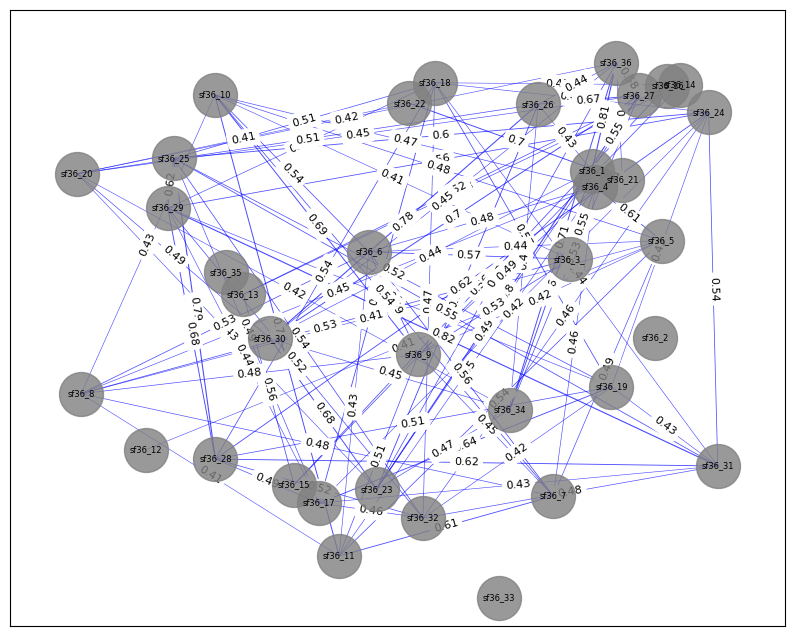

In [23]:
# check graph visual

visualize_graph(sf36)

# Full Correlation

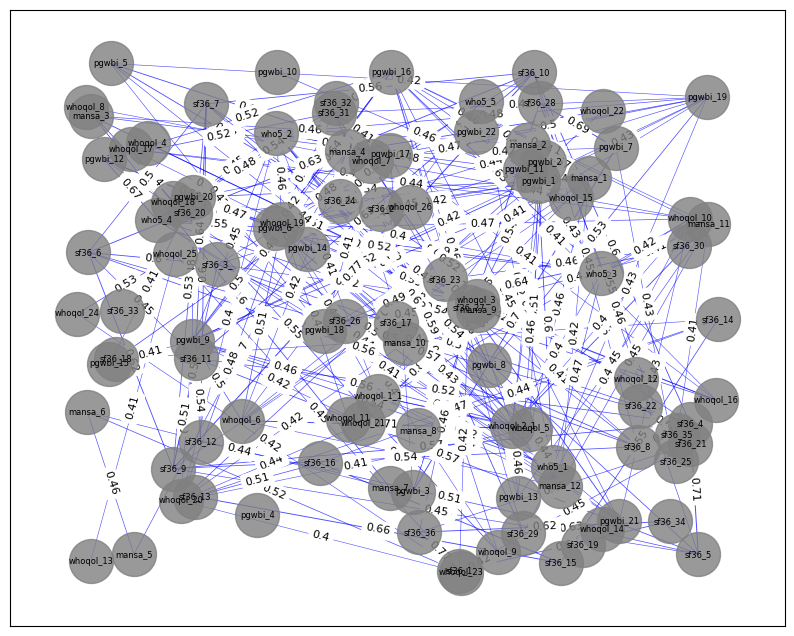

In [24]:
#filter dataframe to tests being used
full_df = df.filter(regex = '^pgwbi|sf36|^who5|^whoqol|^mansa_\d')

#find scores for each test
full_df['who5_score'] = full_df.filter(regex='^who5').sum(axis = 1)
full_df['pgwbi_score'] = full_df.filter(regex='^pgwbi').sum(axis = 1)

full_df['sf36_score'] = full_df.filter(regex='^sf36').mean(axis = 1)
full_df['mansa_score'] = full_df.filter(regex='^mansa').mean(axis = 1)
full_df['whoqol_score'] = full_df.filter(regex='^whoqol').mean(axis = 1)


# filter data frame to above cutoff for each test
filtered_full_df = full_df[(full_df['who5_score'] >  50) & (full_df['pgwbi_score'] > 72) & 
                           (full_df['sf36_score'] > 50) & (full_df['mansa_score'] > 4.56) &
                           (full_df['whoqol_score'] > 60)]

filtered_full_df.drop(['who5_score','pgwbi_score','sf36_score', 'mansa_score', 'whoqol_score'], axis=1, inplace=True)

full_df_corr = filtered_full_df.corr(method = 'spearman')

# update correlation values of 1 and negative to reflect 0s
full_df_corr = full_df_corr.mask(full_df_corr == 1, 0)
full_df_corr = full_df_corr.mask(full_df_corr < 0.4, 0)


visualize_graph(full_df_corr)

# Link Clustering & Write files to GEXF for Gephi

In [26]:
# form link communities for each individual test and the full dataframe

df_list = [mansa, whoqol, who5, pgwbi, sf36, full_df_corr]

name_list = name_list + ['full_corr']

for i in range(len(df_list)):
    G = form_link_comm(df_list[i])    
    nx.write_gexf(G, f'{name_list[i]}.gexf')

clustering...
computing similarities...
# D_max = 0.428571
# S_max = 0.206630
clustering...
computing similarities...
# D_max = 0.357143
# S_max = 0.422074
clustering...
computing similarities...
# D_max = 0.750000
# S_max = 0.221385
clustering...
computing similarities...
# D_max = 0.545455
# S_max = 0.508356
clustering...
computing similarities...
# D_max = 0.899802
# S_max = 0.311432
clustering...
computing similarities...
# D_max = 0.403192
# S_max = 0.488900
